# Building a VMC code while computing the Ground-State of the Ising model: Part 2

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/2307_Trento/2_qgt_dynamics.ipynb) 

Let's get back to our dear old beautiful Ising hamiltonian

$$ 
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}. 
$$

In the following we assume periodic boundary conditions.

## 0. Installing Netket

If you are executing this notebook on Colab, you will need to install netket. You can do so by running the following cell:

In [1]:
# %pip install --quiet netket

We also want make to sure that this notebook is running on the cpu. 
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want. 
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

Make sure that you are running on python at least 3.8, and that the installed NetKet version is at least 3.9.1. 
Note that this notebook won't run on Python versions prior to 3.8 and on NetKet versions prior to 3.9.1 .
In general, conda might not have the most up-to-date version of netket.

In [3]:
import platform
import netket as nk

print("Your version of python is: ", platform.python_version())
print("Your version of netket is: ", nk.__version__)

Your version of python is:  3.11.2
Your version of netket is:  3.9.dev40+g331ec7223.d20230723


*After* having defined this environment variable, we can load netket and the various libraries that we will be using throughout the tutorial.

In [4]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# jax and jax.numpy
import jax
import jax.numpy as jnp

#
from functools import partial
from tqdm import tqdm

## 1. Preparations

### 1.1 Define the Hamiltonians

Let's consider as before an Ising model on a 2D lattice with periodic boundary conditions (pbc).

In [5]:
# Define a 2D square lattice
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

In [6]:
# Define the Hilbert space based on this graph
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

In [7]:
# TODO

hamiltonian = nk.operator.LocalOperator(hi) # This creates an empty operator to which you can add others.

for site in g.nodes():
    hamiltonian = hamiltonian - 1.0 * nk.operator.spin.sigmax(hi, site)

for (i,j) in g.edges():
    hamiltonian = hamiltonian + nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j)

hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

### 1.2 Exact Diagonalization (as a testbed)

Get the solution with exact diagonalisation

In [8]:
import scipy as sp

e_gs, psi_gs = sp.sparse.linalg.eigsh( hamiltonian.to_sparse(), k=1)

e_gs = e_gs[0]
psi_gs = psi_gs[:,0]

### 1.3 Variational Ansatz & variational energy

We consider a Jastrow Ansatz

In [9]:
import flax
import flax.linen as nn

from netket.utils.types import DType, Array, NNInitFunc

class Jastrow(nn.Module):
    r"""
    Jastrow wave function :math:`\Psi(s) = \exp(\sum_{ij} s_i W_{ij} s_j)`.

    The W matrix is stored as a non-symmetric matrix, and symmetrized
    during computation by doing :code:`W = W + W.T` in the computation.
    """

    param_dtype: DType = jnp.float64
    """The dtype of the weights."""
    kernel_init: NNInitFunc = jax.nn.initializers.normal()
    """Initializer for the weights."""

    @nn.compact
    def __call__(self, x_in: Array):
        nv = x_in.shape[-1]

        kernel = self.param("kernel", self.kernel_init, (nv, nv), self.param_dtype)
        kernel = kernel + kernel.T

        kernel, x_in = flax.linen.dtypes.promote_dtype(kernel, x_in, dtype=None)
        y = jnp.einsum("...i,ij,...j", x_in, kernel, x_in)

        return y


In [10]:
from typing import Any, Union

class RBM(nn.Module):
    r"""A restricted boltzman Machine, equivalent to a 2-layer FFNN with a
    nonlinear activation function in between.
    """

    param_dtype: DType = np.float64
    """The dtype of the weights."""
    activation: Any = nk.nn.reim_selu
    """The nonlinear activation function."""
    alpha: Union[float, int] = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""

    kernel_init: NNInitFunc = jax.nn.initializers.normal(stddev=0.01)
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = jax.nn.initializers.normal(stddev=0.01)
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = jax.nn.initializers.normal(stddev=0.01)
    """Initializer for the visible bias."""

    @nn.compact
    def __call__(self, input):
        x = nn.Dense(
            name="Dense",
            features=int(self.alpha * input.shape[-1]),
            param_dtype=self.param_dtype,
            use_bias=self.use_hidden_bias,
            kernel_init=self.kernel_init,
            bias_init=self.hidden_bias_init,
        )(input)
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        if self.use_visible_bias:
            v_bias = self.param(
                "visible_bias",
                self.visible_bias_init,
                (input.shape[-1],),
                self.param_dtype,
            )
            out_bias = jnp.dot(input, v_bias)
            return x + out_bias
        else:
            return x

### 1.4. Utilities

Remember that your function `model.apply` will evaluate `logpsi`, not the wavefunction itself. 

Write a function that takes as input the model and the parameters, and which returns the exponentiated wavefunction, properly normalised.


In [11]:
@partial(jax.jit, static_argnames='model')
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

@partial(jax.jit, static_argnames="model")
def compute_energy(model, parameters, hamiltonian_sparse):
    psi_gs = to_array(model, parameters)
    return psi_gs.conj().T@(hamiltonian_sparse@psi_gs)

@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, parameters, hamiltonian_sparse)

# MC
@partial(jax.jit, static_argnames='model')
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    return jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)

@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

# @partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree_map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)

    return E, E_grad

## 2. Natural Gradient, aka Stochastic Reconfiguration

Natural gradient descent uses information about the structure of the neural network to compute the 'gradient' according to the metric for the space of parameters (stretches and contracts euclidean space). This is what is called the Fubini-Study metric. Distances are represented by the angle between the vectors that represent the quantum states for parameters $\theta$ and $\theta '$:

$$
d(\psi_\theta, \psi_{\theta '}) = \arccos \left(|\langle \psi_\theta|\psi_{\theta '} \rangle | \right)
$$

Using the good old trick of Taylor expanding things, we can find the infinitesimal squared line element:

$$
d^2(\psi_\theta, \psi_{\theta+\delta\theta}) = \sum_{ij} g_{ij}(\theta) \delta \theta_i \delta \theta_j,
$$

where $g_{ij}(\theta)$ is the metric tensor derived from the Fubini-Study metric:

$$
g_{ij} = \Re \left[ \left \langle \frac{  \partial \psi_\theta}{\partial \theta_i} |\frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle - \left \langle \frac{ \partial \psi_\theta}{\partial \theta_i} |\psi_\theta \right\rangle \left\langle \psi_\theta| \frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle  \right].
$$

Now that we have the infinitesimal squared line element, we can find the extremum of the variation of energy and distance in parameter space upon changing the parameters:

$$
L = E_{\theta + \delta \theta} + \lambda (d^2-\epsilon) = E_\theta + \sum_k \frac{\partial E_\theta}{\partial\theta_k} \delta\theta_k + \lambda \left( \sum_{kk'} g_{kk'}(\theta) \delta \theta_k \delta \theta_{k'} -\epsilon \right).
$$

The minimum of that function with respect to $\delta \theta$ is reached when $\frac{\partial L}{\partial (\delta\theta_m)} = 0$:

$$
\sum_{k'} g_{kk'}(\theta) \delta \theta_{k'} = -\frac{1}{2\lambda} \frac{\partial E_\theta}{\partial \theta_k},
$$

a system of linear equations that we need to solve (numerically). Please note the comparison of the update rule between natural and vanilla gradient descent:

$$
\delta \theta_k = -\frac{1}{2\lambda} \frac{\partial E_\theta}{\partial \theta_k}.
$$

### 2.1 Building the S matrix In practice : part 1, the jacobian

You want to compute The Quantum Geometric Tensor

$$
S_{ij} = \Re \left[ \left \langle \frac{  \partial \psi_\theta}{\partial \theta_i} |\frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle - \left \langle \frac{ \partial \psi_\theta}{\partial \theta_i} |\psi_\theta \right\rangle \left\langle \psi_\theta| \frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle  \right] \\
= \Re \left[ \sum_x \frac{|\psi(x)|^2}{\langle\psi|\psi\rangle} (\partial_i \log\psi(x) - \langle\partial_i \log\psi \rangle)^\star (\partial_j \log\psi(x) - \langle\partial_j \log\psi \rangle) \right] 
$$

and the gradient of the energy

$$
f_i = \text{as before}
$$

and update the parameters according to $\theta_k$ which is computed by solving the linear system of equatins

$$
S_{ij}\delta\theta_j = f_i
$$

#### Step one, computing the Quantum Geometric Tensor

How can we easily get the Quantum Geometric tensor? If we could write everything in terms of a jacobian life would be a lot easier.

So, there is a trick to abandom the world of pytrees and go to the world where all parameters are just a vector. It's a function called `jax.flatten_util.ravel_pytree`, which takes a pytree and returns a `vector` of concatenated parameters as well as a function to unpack the concatenated parameters in the original shape.

See below an example

In [12]:
model = Jastrow()
parameters = model.init(jax.random.PRNGKey(1), jnp.ones(hi.size,))

# we have parameters, a complicated object
print("structure of parameters:", jax.tree_map(lambda x: (x.shape, x.dtype), parameters))

# Let's ravel it into a vector
parameters_flat, unravel = jax.flatten_util.ravel_pytree(parameters)

print("structure of parameters_flat:", parameters_flat.shape, parameters_flat.dtype)

# now i can modify the flattened parameters, for example by moltiplying them by 0
parameters_flat_new = parameters_flat*0

# unravel the new parameters
unraveked_pars = unravel(parameters_flat_new)

print("structure of new unraveled parameters:", jax.tree_map(lambda x: (x.shape, x.dtype), unraveked_pars))


structure of parameters: FrozenDict({
    params: {
        kernel: ((16, 16), dtype('float64')),
    },
})
structure of parameters_flat: (256,) float64
structure of new unraveled parameters: FrozenDict({
    params: {
        kernel: ((16, 16), dtype('float64')),
    },
})


So now we can define a new function that takes as input the raveled parameters and returns the log wavefunction as usual. You could for example unflatten inside of it.

In [13]:
def flattened_log_wavefunction(model, unravel_fun, flat_parameters, samples):
    assert flat_parameters.ndim == 1
    # todo
    ...
    res = model.apply(...)
    ...
    return res

In [14]:
# todelete
def flattened_log_wavefunction(model, unravel_fun, flat_parameters, samples):
    assert flat_parameters.ndim == 1
    res = model.apply(unravel_fun(flat_parameters), samples)
    return res

In [15]:
# tests
parameters_flat, unravel_fun = jax.flatten_util.ravel_pytree(parameters)
samples = hi.random_state(jax.random.PRNGKey(3), (10,))

assert flattened_log_wavefunction(model, unravel_fun, parameters_flat, samples).shape == (10,)

Now we can also compute the jacobian of this function with relative ease. This time, the jacobian should be a dense matrix. To do that, first build the callable that only takes as input the parameters then use `jax.jacrev` on it.

In [16]:
# once your code works correctly, uncomment this line to jit it.
# don't do it immediately because the error messages are harder to read then.
@partial(jax.jit, static_argnames='model')
def compute_jacobian(model, parameters, samples):
    # enure we just have a long batch of samples
    samples = samples.reshape(-1, samples.shape[-1])

    parameters_flat, unravel_fun = jax.flatten_util.ravel_pytree(parameters)
    def _fun(pars_flat, samples):
        # todo
        ...
        return log_wavefunciton_for_samples
    
    # this line checks that the code works correctly. Check that it works then delete it
    assert _fun(parameters_flat, samples).shape == (samples.shape[0],)
    
    def _compute_single_gradient(pars_flat, single_sample):
        # only differentiate wrt to parameters, not samples
        # compute the gradient of _fun... by using jax.grad
        return ...
    
    # this line checks that the code works correctly. Check that it works then delete it
    assert _compute_single_gradient(parameters_flat, samples[0]).shape == (parameters_flat.shape[0],)
    
    # vmap along samples (2nd argument) but not along parameters (1st argument)
    _compute_gradient = jax.vmap(_compute_single_gradient, in_axes=(??, ??))
    
    # this line checks that the code works correctly. Check that it works then delete it
    return _compute_gradient(parameters_flat, samples)

SyntaxError: invalid syntax (4168761804.py, line 26)

In [17]:
# todelete
@partial(jax.jit, static_argnames='model')
def compute_jacobian(model, parameters, samples):
    # enure we just have a long batch of samples
    samples = samples.reshape(-1, samples.shape[-1])

    parameters_flat, unravel_fun = jax.flatten_util.ravel_pytree(parameters)
    def _fun(pars_flat, samples):
        return model.apply(unravel_fun(pars_flat), samples)
    
    # this line checks that the code works correctly. Check that it works then delete it
    assert _fun(parameters_flat, samples).shape == (samples.shape[0],)
    
    def _compute_single_gradient(pars_flat, single_sample):
        # only differentiate wrt to parameters, not samples
        return jax.grad(_fun, argnums=0)(pars_flat, single_sample)
    
    # this line checks that the code works correctly. Check that it works then delete it
    assert _compute_single_gradient(parameters_flat, samples[0]).shape == (parameters_flat.shape[0],)
    
    # vmap along samples (2nd argument) but not along parameters (1st argument)
    _compute_gradient = jax.vmap(_compute_single_gradient, in_axes=(None, 0))
    
    # this line checks that the code works correctly. Check that it works then delete it
    return _compute_gradient(parameters_flat, samples)

In [18]:
# tests
assert compute_jacobian(model, parameters, samples).shape == (samples.shape[0], nk.jax.tree_size(parameters))

### 2.2 Building the S matrix In practice : part 2, the S matrix itself

Use this building block, the jacobian, and the function to compute the dense representation of the wavefunction to compute the full S matrix exactly, without sampling

In [19]:
# @partial(jax.jit, static_argnames='model')
def compute_S_matrix(model, parameters):
    samples = hi.all_states()
    
    J = compute_jacobian(model, parameters, samples)
    
    # compute the vector of probability distribution p(samples)
    # do not use to_array(), for additional speed, but reimplement it here.
    probs = ...
    
    # now compute <d_k logpsi> = \sum_i p_i J_ik
    J_avg = ...
    
    # check
    assert J_avg.shape == nk.jax.tree_size(parameters)
    
    # Now center the Jacobianby subtracting its average by cmputing J_ik - <J>_i
    J_centered = J - ... # might be useful to jnp.expand_dims...
    
    # now compute the full S Matrix by averaging 
    S = ...
    
    return S

In [20]:
# todelete
@partial(jax.jit, static_argnames='model')
def compute_S_matrix(model, parameters):
    samples = hi.all_states()
    
    J = compute_jacobian(model, parameters, samples)
    
    # compute the vector of probability distribution p(samples)
    psi = jnp.exp(model.apply(parameters, samples))
    psi = psi/jnp.linalg.norm(psi)
    p = jnp.abs(psi)**2
    
    # now compute <d_k logpsi> = \sum_i p_i J_ik
    p_r = p.reshape(-1, 1)
    J_avg = jnp.mean(p_r*J, axis=0, keepdims=True)
    
    # check
    # Now center the Jacobianby subtracting its average by cmputing J_ik - <J>_i
    J_centered = J - J_avg
    
    # now compute the full S Matrix by averaging 
    return J_centered.conj().T@(p_r * J_centered)

In [21]:
# check shape
assert compute_S_matrix(model, parameters).shape == (nk.jax.tree_size(parameters), nk.jax.tree_size(parameters))

# check hermitian
np.testing.assert_allclose(compute_S_matrix(model, parameters), compute_S_matrix(model, parameters).conj().T)
# check positive semidefeinite (approximately)
np.all(jnp.linalg.eigh(compute_S_matrix(model, parameters))[0] > -1e-14)

2023-07-24 23:52:57.611669: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %dot.4 = f64[65536,16,16]{2,1,0} dot(f64[65536,16]{1,0} %constant.13, f64[65536,16]{1,0} %constant.15), lhs_batch_dims={0}, lhs_contracting_dims={}, rhs_batch_dims={0}, rhs_contracting_dims={}, metadata={op_name="jit(compute_S_matrix)/jit(main)/jit(compute_jacobian)/vmap(transpose(vmap(jvp(Jastrow))))/...i,ij,...j/dot_general[dimension_numbers=(((), ()), ((0,), (0,))) precision=None preferred_element_type=None]" source_file="/var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/ipykernel_18627/677488096.py" source_line=27}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envva

Array(True, dtype=bool)

### 2.3 Computing the natural gradient

With this code, now we can try to build the linear system and solve it to compute the solution of a step!

dtheta = solve(S, F)

In [22]:
@partial(jax.jit, static_argnames='model')
def compute_energy_and_natural_gradient(model, parameters, hamiltonian_jax_sparse):
    
    S_flat = compute_S_matrix(model, parameters)
    
    E, F = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    
    # Since S is a dense matrix, you must ravel F to something dense as well
    F_flat = ...
    
    # Now S_flat and F_flat are both dense matrix/vector. You can use linear solvers to solve the linear
    # system. Options are conjugate gradients (jax.scipy.sparse.linalg.cg) or similar methods
    dtheta_flat = ...
    
    # dtheta is a dense vector, but the gradient should be a pytree. Unravel it back to the original structure
    dtheta = ...
    
    return E, dtheta

In [29]:
# todelete
@partial(jax.jit, static_argnames='model')
def compute_energy_and_natural_gradient(model, parameters, hamiltonian_jax_sparse):
    
    S_flat = compute_S_matrix(model, parameters)
    
    E, F = compute_energy_and_gradient(model, parameters, hamiltonian_jax_sparse)
    
    # Since S is a dense matrix, you must ravel F to something dense as well
    F_flat, unravel_fun = jax.flatten_util.ravel_pytree(F)
    
    # Now S_flat and F_flat are both dense matrix/vector. You can use linear solvers to solve the linear
    # system. Options are conjugate gradients (jax.scipy.sparse.linalg.cg) or similar methods
    dtheta_flat, info = jax.scipy.sparse.linalg.cg(S_flat, F_flat)
    
    # dtheta is a dense vector, but the gradient should be a pytree. Unravel it back to the original structure
    dtheta = unravel_fun(dtheta_flat)
    
    return E, dtheta

In [31]:
assert len(compute_energy_and_natural_gradient(model, parameters, hamiltonian_jax.to_sparse())) == 2


In [33]:
E, natgrad = compute_energy_and_natural_gradient(model, parameters, hamiltonian_jax.to_sparse())

### 2.3 Finding the ground state with the natural gradient

Now write a small training loop like we did yesterday using the Natural gradient instead of the standard gradient. Then, run both optimisations (using gradient and natural gradient) and compare the two.

If you are using netket's loggers, use two different loggers, one called `logger_natgrad` and one called `logger_grad` for the two different optimisation runs.

Try to initialise both runs with exactly the same parameters (use the same random seed) to see what is going on...

In [38]:
model = Jastrow()
parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))

hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

logger_grad = nk.logging.RuntimeLog()

for i in tqdm(range(100)):
    ...

100%|██████████| 100/100 [00:01<00:00, 77.20it/s]


In [ ]:
# todo
# same for natgrad

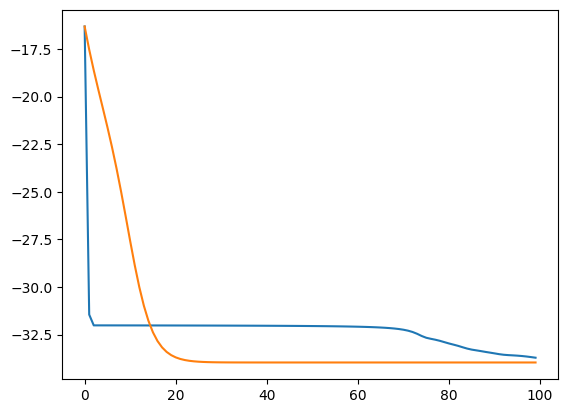

In [39]:
# to plot the data, access it!
plt.plot(logger_grad.data['Energy']['iters'], logger_grad.data['Energy']['value'])
plt.plot(logger_natgrad.data['Energy']['iters'], logger_natgrad.data['Energy']['value'])

But actually a better plot would be in log-scale, the relative error wrt the exact solution. Do that!

## 3.1 Natural gradient with MC sampling

Until now we did things without sampling. Let's try to get it working with sampling now.

The gradient `F` of the energy we have already with sampling thanks to the function `estimate_energy_and_gradient`. 
We just need to estimate the `S` matrix.

The formula will be 
$$
S_{ij} = = \Re \left[ \frac{1}{N_s}\sum_x  (\partial_i \log\psi(x) - \langle\partial_i \log\psi \rangle)^\star (\partial_j \log\psi(x) - \langle\partial_j \log\psi \rangle) \right] 
$$

Luckily for us, we already have the code to compute the jacobian given a set of samples, so we just need to rewrite the code to patch it together and get the S matrix.

In [ ]:
# @partial(jax.jit, static_argnames='model')
def estimate_S_matrix(model, parameters, samples):
     J = compute_jacobian(model, parameters, samples)
    
    # now compute <d_k logpsi> = 1/Ns \sum_i J_ik
    J_avg = ...
    
    # check
    
    # Now center the Jacobianby subtracting its average by cmputing J_ik - <J>_i
    J_centered = J - ... # might be useful to jnp.expand_dims...
    
    # now compute the full S Matrix by summing over the batch dimension
    S = ...
    
    return S

In [48]:
#todelete
@partial(jax.jit, static_argnames='model')
def estimate_S_matrix(model, parameters, samples):
    J = compute_jacobian(model, parameters, samples)
    
    # now compute <d_k logpsi> = 1/Ns \sum_i J_ik
    J_avg = jnp.mean(J, keepdims=True, axis=0)
    
    # Now center the Jacobianby subtracting its average by cmputing J_ik - <J>_i
    J_centered = J - J_avg # might be useful to jnp.expand_dims...
    
    # now compute the full S Matrix by summing over the batch dimension
    S = J_centered.conj().T@J_centered
    
    return S

In [57]:
fake_samples = hi.random_state(jax.random.PRNGKey(0), (50,))

assert estimate_S_matrix(model, parameters, fake_samples).shape == (nk.jax.tree_size(parameters), 
                                                                    nk.jax.tree_size(parameters))

# check hermitian
np.testing.assert_allclose(estimate_S_matrix(model, parameters, fake_samples), 
                           estimate_S_matrix(model, parameters, fake_samples).conj().T)
# check positive semidefeinite (approximately)
assert np.all(jnp.linalg.eigh(estimate_S_matrix(model, parameters, fake_samples))[0] > -1e-12)

And now write the code to estimate the natural gradient using the estimation of the S matrix.
This will be almost identical to the one you wrote for `compute_energy_and_natural_gradient`

In [ ]:
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_natural_gradient(model, parameters, hamiltonian_jax_sparse, samples):
    
    S_flat = compute_S_matrix(model, parameters, samples)
    
    E, F = estimate_energy_and_gradient(model, parameters, hamiltonian_jax_sparse, samples)
    
    # Since S is a dense matrix, you must ravel F to something dense as well
    F_flat = ...
    
    # Now S_flat and F_flat are both dense matrix/vector. You can use linear solvers to solve the linear
    # system. Options are conjugate gradients (jax.scipy.sparse.linalg.cg) or similar methods
    dtheta_flat = ...
    
    # dtheta is a dense vector, but the gradient should be a pytree. Unravel it back to the original structure
    dtheta = ...
    
    return E, dtheta

### 3.3 Use it in practice

Run a calculation using Monte Carlo integration using an RBM neural network. 
Compare the result to the result you find with standard gradient descent.

Which one is better?

It's highly likely that the natural gradient optimisation will not be stable and will explode all the time. This is usually due to the fact that the S matrix, while technically positive definite, it no longer is due to sampling. The strategy usually employed is to regularise it by adding a small shift (1e-3) to its diagonal.

If you have problems converging, try using this to stabilise it.

Finally, try to compute the magnetization of the ground state that you found like that, compare against the exact solution. Which Network is better?

In [ ]:
from tqdm import tqdm

# settings 
model = RBM()
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.LocalRule(),  # the transition rule
                        n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initialise
parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_natural_gradient(model, parameters, hamiltonian_jax, samples)
    
    # update parameters. Try using a learning rate of 0.01
    ...
    
    # log energy: the logger takes a step argument and a dictionary of variables to be logged
    logger(step=i, item={'Energy':E})

### 4 Symmetric Neural Network

Let's consider the symmetries of this lattice. Luckily, netket is lovely and gives to us the translation group (as well as others)

In [62]:
G = g.translation_group()
G

PermutationGroup(elems=[Id(), Translation([0, 1]), Translation([0, 2]), Translation([0, 3]), Translation([1, 0]), Translation([1, 1]), Translation([1, 2]), Translation([1, 3]), Translation([2, 0]), Translation([2, 1]), Translation([2, 2]), Translation([2, 3]), Translation([3, 0]), Translation([3, 1]), Translation([3, 2]), Translation([3, 3])], degree=16)

the way this object works is that if you apply it to samples, it gives you the translated samples. Look!

In [71]:
# let's take one element of the hilbert space
x = hi.numbers_to_states(400)
print(x)

# compute all element in the orbit of this state
ys = G@x
# it has shape (16,16) because the orbit contains 16 elements
print(ys.shape)
ys

[-1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1.]
(16, 16)


array([[-1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
        -1., -1., -1.],
       [-1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        -1., -1., -1.],
       [-1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,
        -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        -1., -1.,  1.],
       [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
         1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
         1.,  1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        -1.,  1.,  1.],
       [ 1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.,  1.],
       [ 1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        -1., -1., -1.],
       [-1.,  1.,  1., -1., -1

So, we can build a Neural Network that uses this...

$$
        \log\psi_\theta(\sigma) = \log\sum_{g\in G}\chi_g\exp[\log\psi_\theta(T_{g}\sigma)]
$$

where the base $\log\psi_\theta$ is for example the standard RBM network.

In [80]:
symm_group = g.translation_group()

class SymmetrisedRBM(nn.Module):
    non_symmetric_model : nn.Module
    @nn.compact
    def __call__(self, x: Array):
        # apply the group and obtain a x_symm of shape (N_symm, ...)
        x_symm = symm_group @ x
        # reshape it to (-1, N_sites)
        x_symm_shape = x_symm.shape
        x_symm = x_symm.reshape(-1, x.shape[-1])

        # Compute the log-wavefunction obtaining (-1,) and reshape to (N_symm, ...)
        psi_symm = self.non_symmetric_model(x_symm).reshape(*x_symm_shape[:-1])

        # log (sum_i ( c_i* exp(psi[sigma_i])))
        psi = jax.scipy.special.logsumexp(psi_symm, axis=0)
        return psi


In [82]:
model = SymmetrisedRBM(non_symmetric_model=RBM())

parameters = model.init(jax.random.PRNGKey(3), hi.numbers_to_states(3))

Use this model with SGD and Natural Gradient to find the ground state. Which works better? which has the best magnetization of the ground state? what about two body correlations?